# Develop an initial model

In [1]:
# Python modules
import dateutil
from datetime import datetime
import re

# Data science packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit Learn utility classes & functions
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Scikit Learn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor

# Our own code
from src.data.data_builder import DataBuilder, BettingData, MatchData
from src.data.data_transformer import DataTransformer
from src.data.feature_builder import FeatureBuilder
from src.model.metrics import measure_estimators, regression_accuracy

np.random.seed(42)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Set up data and create cumulative features

csv_paths = ('data/afl_betting.csv', 'data/ft_match_list.csv')
data_classes = (BettingData, MatchData)

raw_df = DataBuilder(data_classes, csv_paths).concat()
model_df = DataTransformer(raw_df).stack_teams()
fb = FeatureBuilder(model_df)
fb.transform()
team_df = fb.df.dropna()
team_df

team         oppo_team  \
team             year round_number                                       
Adelaide         2010 2                     Adelaide            Sydney   
                      3                     Adelaide         Melbourne   
                      4                     Adelaide           Carlton   
                      5                     Adelaide  Western Bulldogs   
                      6                     Adelaide     Port Adelaide   
                      7                     Adelaide          Richmond   
                      8                     Adelaide   North Melbourne   
                      9                     Adelaide          Brisbane   
                      10                    Adelaide          St Kilda   
                      11                    Adelaide         Fremantle   
                      12                    Adelaide          Hawthorn   
                      13                    Adelaide         Melbourne   
                      14                    Adelaide          Essendon   
                      15                    Adelaide        West Coast   
                      16                    Adelaide           Geelong   
                      17                    Adelaide     Port Adelaide   
                      18                    Adelaide          Richmond   
                      19                    Adelaide  Western Bulldogs   
                      20                    Adelaide          Brisbane   
                      21                    Adelaide       Collingwood   
                      22                    Adelaide          St Kilda   
                 2011 1                     Adelaide          Hawthorn   
                      3                     Adelaide         Fremantle   
                      4                     Adelaide     Port Adelaide   
                      5                     Adelaide           Carlton   
                      6                     Adelaide          St Kilda   
                      7                     Adelaide         Melbourne   
                      8                     Adelaide        Gold Coast   
                      9                     Adelaide       Collingwood   
                      10                    Adelaide          Brisbane   
...                                              ...               ...   
Western Bulldogs 2015 21            Western Bulldogs        West Coast   
                      22            Western Bulldogs   North Melbourne   
                      23            Western Bulldogs          Brisbane   
                      25            Western Bulldogs          Adelaide   
                 2016 1             Western Bulldogs         Fremantle   
                      2             Western Bulldogs          St Kilda   
                      3             Western Bulldogs          Hawthorn   
                      4             Western Bulldogs           Carlton   
                      5             Western Bulldogs          Brisbane   
                      6             Western Bulldogs   North Melbourne   
                      7             Western Bulldogs          Adelaide   
                      8             Western Bulldogs         Melbourne   
                      9             Western Bulldogs               GWS   
                      10            Western Bulldogs       Collingwood   
                      11            Western Bulldogs        West Coast   
                      12            Western Bulldogs     Port Adelaide   
                      13            Western Bulldogs           Geelong   
                      15            Western Bulldogs            Sydney   
                      16            Western Bulldogs          Richmond   
                      17            Western Bulldogs        Gold Coast   
                      18            Western Bulldogs          St Kilda   
                      19            Western Bulldogs

## Which models perform better on betting/match data?

In [3]:
# Set up & split data for models

team_features = pd.get_dummies(team_df.drop(['score', 'oppo_score'], axis=1))
team_labels = pd.Series(team_df['score'] - team_df['oppo_score'], name='score_diff')
data = train_test_split(team_features, team_labels)

In [4]:
# Pass data to models & measure performance

estimators = (Lasso(),
              ElasticNet(),
              Ridge(),
              LinearSVR(),
              AdaBoostRegressor(),
              BaggingRegressor(),
              ExtraTreesRegressor(),
              GradientBoostingRegressor(),
              RandomForestRegressor(),
              SVR(kernel='rbf'),
              XGBRegressor())

estimator_scores = measure_estimators(estimators, data, model_type='regression')
estimator_scores

,estimator,accuracy,error,std_accuracy,std_error,score_type
0,Lasso,0.720453,28.905977,0.012350,0.660506,cv
1,ElasticNet,0.719028,29.109276,0.013702,0.535231,cv
2,Ridge,0.722347,29.190010,0.010027,0.740480,cv
3,LinearSVR,0.712862,29.323058,0.003983,0.633194,cv
4,AdaBoostRegressor,0.717136,29.472941,0.014747,0.592063,cv
5,BaggingRegressor,0.693874,31.407694,0.021493,1.332351,cv
6,ExtraTreesRegressor,0.692951,31.860986,0.028083,0.853597,cv
7,GradientBoostingRegressor,0.712395,29.877221,0.021326,0.642704,cv
8,RandomForestRegressor,0.688665,31.052658,0.014085,1.149060,cv
9,SVR,0.726152,31.851975,0.009168,0.550119,cv


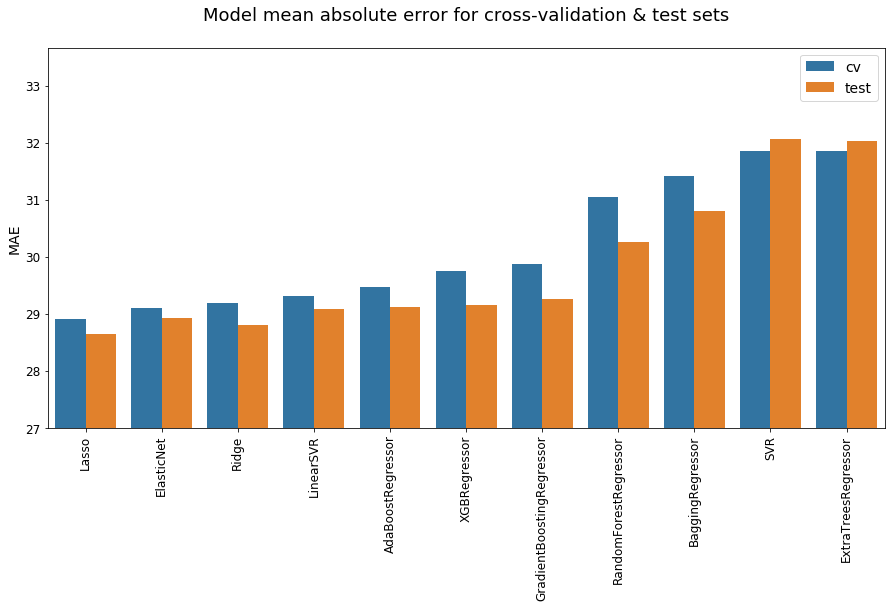

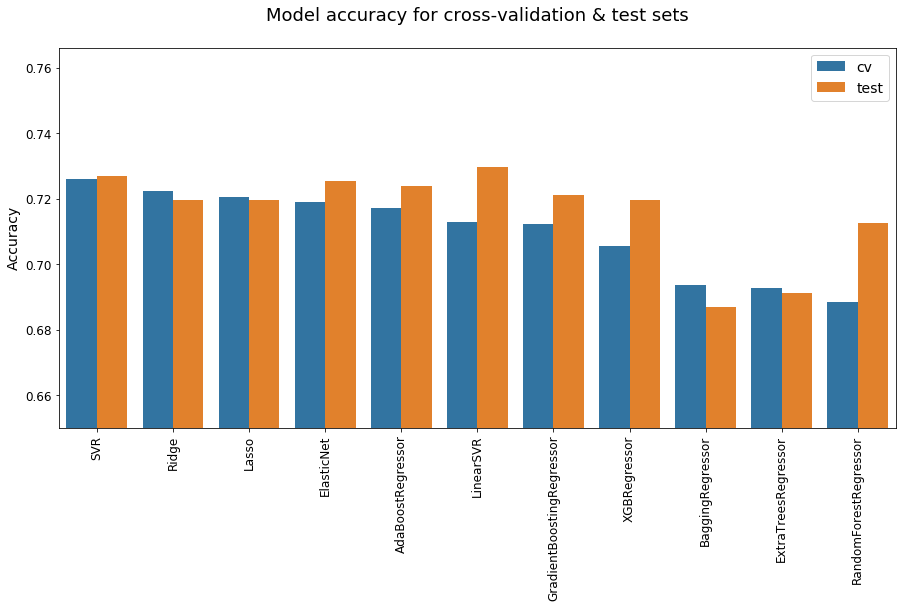

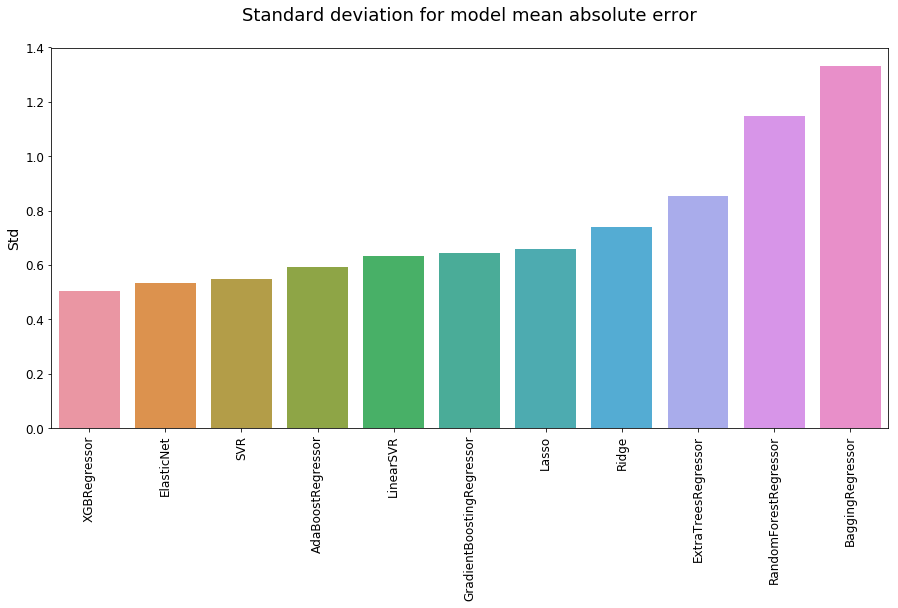

In [13]:
# MAE scores
mae_scores = estimator_scores.sort_values(['score_type', 'error'], ascending=[True, True])

plt.figure(figsize=(15, 7))
sns.barplot(x='estimator', y='error', hue='score_type', data=mae_scores)
plt.ylim(ymin=27)
plt.title('Model mean absolute error for cross-validation & test sets\n', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
acc_scores = mae_scores.sort_values(['score_type', 'accuracy'], ascending=[True, False])

plt.figure(figsize=(15, 7))
sns.barplot(x='estimator', y='accuracy', hue='score_type', data=acc_scores)
plt.ylim(ymin=0.65)
plt.title('Model accuracy for cross-validation & test sets\n', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

# Std scores
std_scores = mae_scores[mae_scores['score_type'] == 'cv'].sort_values('std_error', ascending=True)

plt.figure(figsize=(15, 7))
sns.barplot(x='estimator', y='std_error', data=std_scores)
# plt.ylim(ymin=0.65)
plt.title('Standard deviation for model mean absolute error\n', fontsize=18)
plt.ylabel('Std', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
# plt.legend(fontsize=14)

plt.show()

### Linear models perform better than ensembles

The 'boost' ensembles have comparable performance to the better linear models, but all the linear models get around 29 MAE for both the CV and test scores, with Lasso having the best error scores and Ridge having the 3rd best error and 2nd best accuracy (SVR has terrible error, but the best CV accuracy for some reason).

As expected, ensembles perform better, relatively speaking, when looking at standard deviation, but even then the differences are small and both types of models are spread from best to worst.

## Does reducing the number of features make a difference?

In [6]:
# Try a stripped-down set of features to see if certain models are over-fitting and perform better with fewer features
# relative to other models

min_features = pd.get_dummies(team_df[['team', 'oppo_team', 'line_odds', 'year', 'round_number', 'at_home']])

X_train, X_test = data[:2]
train_index = X_train.index
test_index = X_test.index

min_data = (min_features.loc[train_index, :],
            min_features.loc[test_index, :],
            data[2],
            data[3])

min_estimator_scores = measure_estimators(estimators, min_data, model_type='regression')

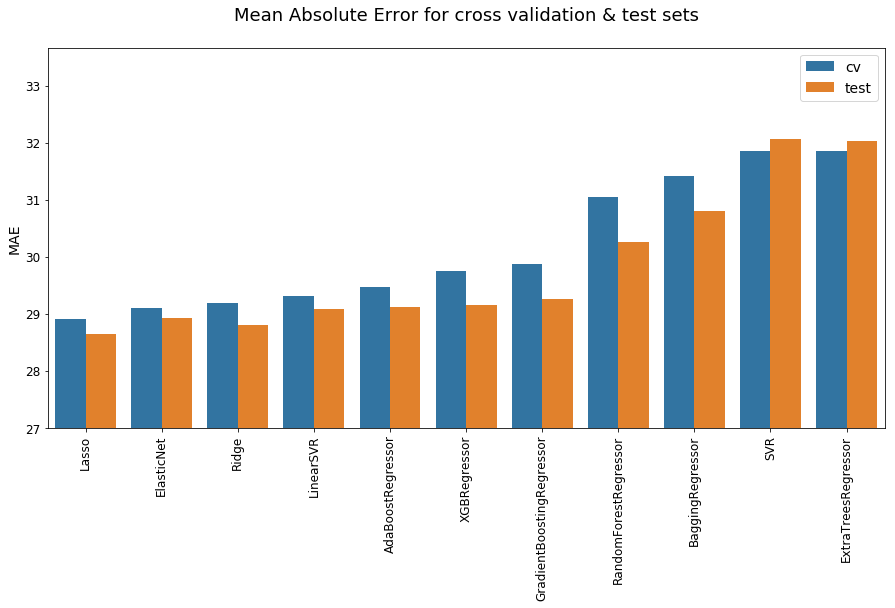

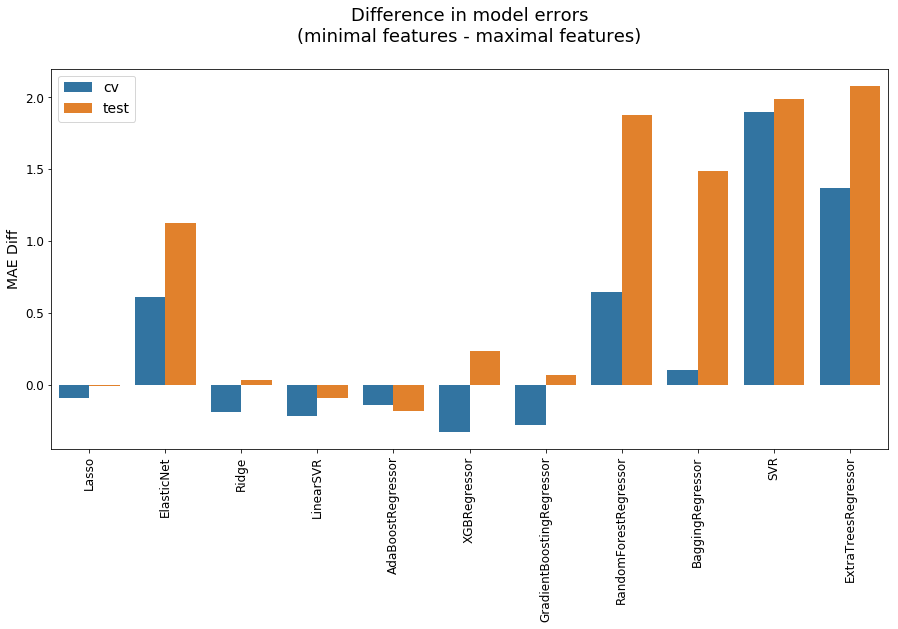

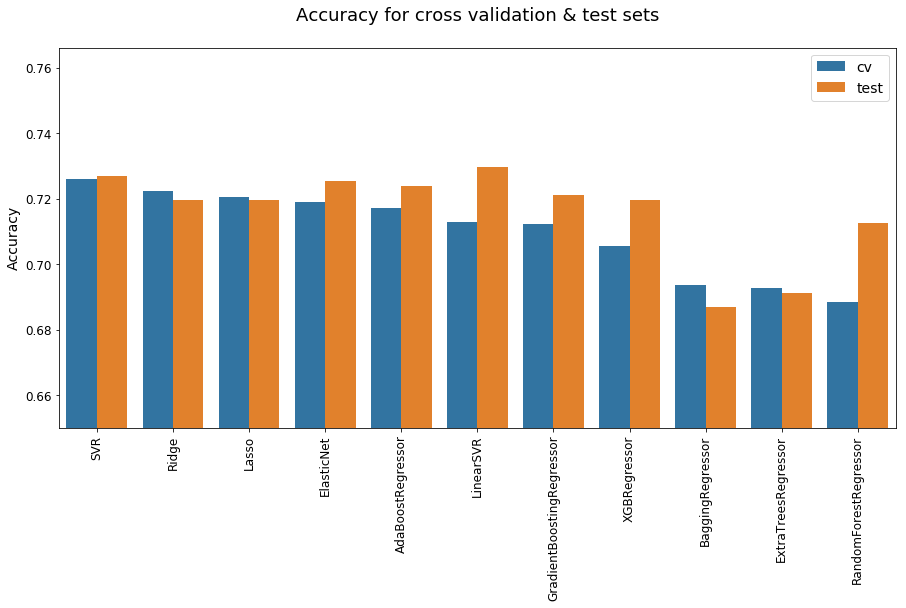

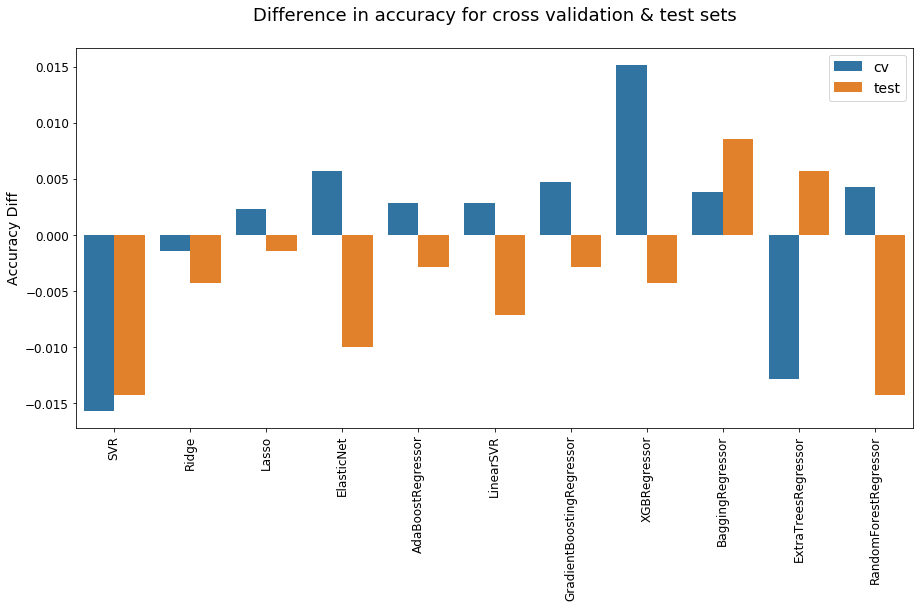

In [14]:
# MAE scores
min_mae_scores = (min_estimator_scores.merge(mae_scores, on=['estimator', 'score_type'], suffixes=('_min', ''))
                                      .assign(error_diff=lambda x: x['error_min'] - x['error'],
                                              accuracy_diff=lambda x: x['accuracy_min'] - x['accuracy'])
                                      .sort_values(['score_type', 'error'], ascending=[True, True]))

plt.figure(figsize=(15, 7))
sns.barplot(x='estimator', y='error', hue='score_type', data=min_mae_scores)
plt.ylim(ymin=27)
plt.title('Mean Absolute Error for cross validation & test sets\n', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

plt.figure(figsize=(15, 7))
sns.barplot(x='estimator', y='error_diff', hue='score_type', data=min_mae_scores)
plt.title('Difference in model errors\n(minimal features - maximal features)\n', fontsize=18)
plt.ylabel('MAE Diff', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
min_acc_scores = min_mae_scores.sort_values(['score_type', 'accuracy'], ascending=[True, False])

plt.figure(figsize=(15, 7))
sns.barplot(x='estimator', y='accuracy', hue='score_type', data=min_acc_scores)
plt.ylim(ymin=0.65)
plt.title('Accuracy for cross validation & test sets\n', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

plt.figure(figsize=(15, 7))
sns.barplot(x='estimator', y='accuracy_diff', hue='score_type', data=min_acc_scores)
plt.title('Difference in accuracy for cross validation & test sets\n', fontsize=18)
plt.ylabel('Accuracy Diff', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Linear models are still the best

Even with fewer features to prevent the ensemble models from overfitting, the linear models tend to perform better, and Lasso is still best-performing. It does improve performance on the test set for most models, so we'll want to remove or compress features as part of our model tuning.

## Is Lasso, ElasticNet, or Ridge better?

Lasso and ElasticNet generally have the lowest MAE scores and are in the top half for accuracy. Ridge has worse CV scores but particularly good test set scores, which means it either generalises very well or is just lucky with the train/test splits.

In [8]:
# Round 24 represents first finals round and doesn't count for tipping competitions
tipping_features = team_features[team_features['round_number'] < 25]
tipping_labels = team_labels[tipping_features.index.values]

lasso = make_pipeline(StandardScaler(), Lasso())
en = make_pipeline(StandardScaler(), ElasticNet())
ridge = make_pipeline(StandardScaler(), Ridge())

estimators = (lasso, en, ridge)

model_names = []
errors = []
accuracies = []
years = []

for year in range(2011, 2017):
    X_train = tipping_features[tipping_features['year'] < year]
    X_test = tipping_features[tipping_features['year'] == year]
    y_train = tipping_labels.loc[X_train.index]
    y_test = tipping_labels.loc[X_test.index]
    
    for estimator in estimators:
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)

        years.append(year)
        model_names.append(estimator.steps[-1][0])
        errors.append(mean_absolute_error(y_test, y_pred))
        accuracies.append(regression_accuracy(y_test, y_pred))
        
year_scores = pd.DataFrame({'model': model_names,
                            'year': years,
                            'error': errors,
                            'accuracy': accuracies})
year_scores

,model,year,error,accuracy
0,lasso,2011,29.946735,0.755376
1,elasticnet,2011,29.938638,0.747312
2,ridge,2011,40.452682,0.602151
3,lasso,2012,29.726227,0.763959
4,elasticnet,2012,29.820344,0.769036
5,ridge,2012,31.755034,0.756345
6,lasso,2013,26.514910,0.734848
7,elasticnet,2013,26.853626,0.704545
8,ridge,2013,27.643913,0.712121
9,lasso,2014,27.939893,0.717172


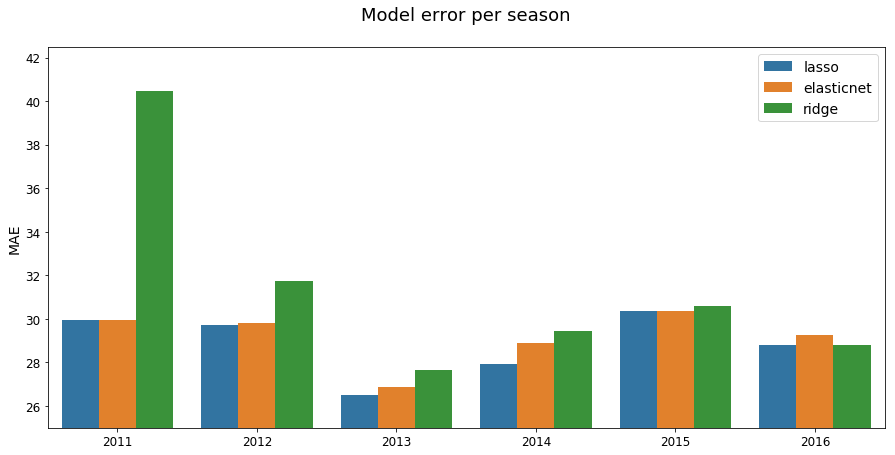

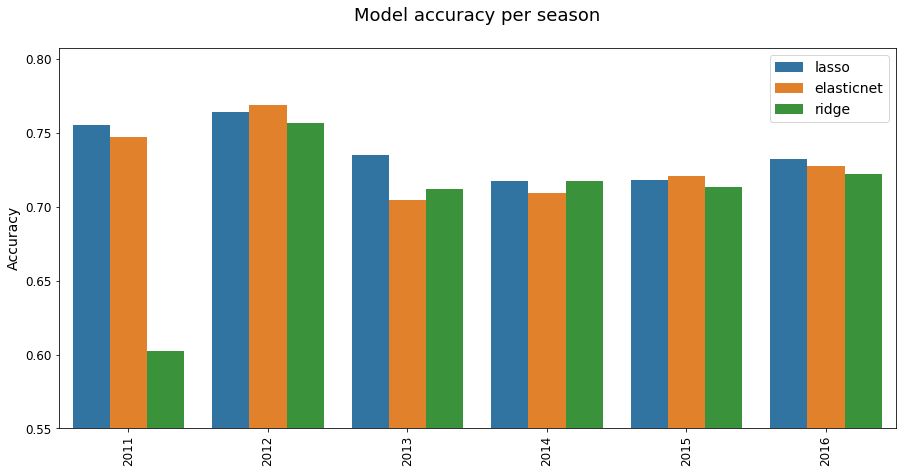

In [15]:
# MAE scores
plt.figure(figsize=(15, 7))
sns.barplot(x='year', y='error', hue='model', data=year_scores)
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(ymin=25)
plt.title('Model error per season\n', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
plt.figure(figsize=(15, 7))
sns.barplot(x='year', y='accuracy', hue='model', data=year_scores)
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(ymin=0.55)
plt.title('Model accuracy per season\n', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Lasso is the best model

Lasso has the lowest MAE 5 out of 6 seasons (with 2 of those basically ties, and the one where ElasticNet is best also being basically a tie). As shown in other comparisons, accuracy is a bit more random, resulting in a wider spread of winners: Lasso is most accurate for 4 seasons (1 of which it ties with Ridge), ElasticNet for 2, and Ridge tied for 1.

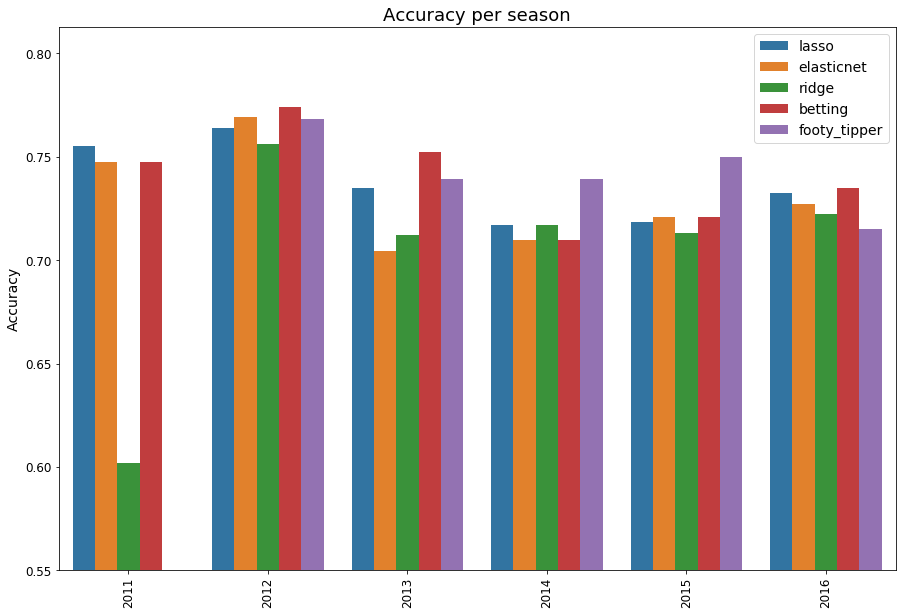

In [10]:
# Accuracy scores with betting accuracy & footy tipper

betting_scores = (((team_df['line_odds'] < 0) & (team_df['score'] >= team_df['oppo_score']) |
                   (team_df['line_odds'] > 0) & (team_df['score'] <= team_df['oppo_score']))
                  .loc[tipping_features[tipping_features['year'] > 2010].index.values]
                  .rename('accuracy')
                  .groupby(level=1)
                  .mean()
                  .reset_index()
                  .assign(model='betting', error=0))
# Footy tipper accuracy scores taken from a trial that took too long to run,
# so I'm just copy pasting from a notebook
footy_tipper_scores = pd.DataFrame({'model': ['footy_tipper'] * len(range(2012, 2017)),
                                    'year': list(range(2012, 2017)),
                                    'error': [0] * len(range(2012, 2017)),
                                    'accuracy': [0.768116, 0.739130, 0.739130, 0.750000, 0.714976]})

plt.figure(figsize=(15, 10))
sns.barplot(x='year',
            y='accuracy',
            hue='model',
            data=year_scores.append([betting_scores, footy_tipper_scores], sort=False))
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(ymin=0.55)
plt.title('Accuracy per season', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

Even without any tuning, a lasso model performs reasonably well, beating the betting odds in 2 seasons (vs 2 for Footy Tipper and 3 ties for ElasticNet interestingly) and beating the fully-tuned Footy Tipper ensemble 1 out of 5 times (with ElasticNet beating it twice). Pretty good start.

Winners: Lasso, Betting, Betting, FootyTipper, FootyTipper, Betting

2nd: ElasticNet/Betting, ElasticNet, FootyTipper, Lasso/Ridge, ElasticNet/Betting, Lasso

There is some evidence in the season breakdown to suggest that ElasticNet will perform better on a per-season basis, but the sample size is pretty small, and MAE is a more-reliable metric for model quality as (per the MoS blog post) accuracy suffers from much higher variance.